<a href="https://colab.research.google.com/github/deanhadzi/DS-Unit-2-Kaggle-Challenge/blob/master/module2/assignment_kaggle_challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [x] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [x] Continue to participate in our Kaggle challenge.
- [x] Try Ordinal Encoding.
- [x] Try a Random Forest Classifier.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

In [0]:
# Importing necessary libraries and modules.

import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

In [32]:
train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              random_state=42, stratify=train['status_group'])

train.shape, val.shape

((47520, 41), (11880, 41))

In [0]:
def wrangle(X):
    """Wrangle data frames"""

    # Prevent SettingWithCopyWarning
    X = X.copy()

    # Dropping redundant columns.
    X = X.drop(columns=['quantity_group', 'recorded_by', 'num_private', 
                        'payment_type', 'id'])

    # Replace small latitudes with zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # Start selecting the numeric features.
    numeric = X.select_dtypes('number').columns.tolist()

    # Replace all zeros in numeric features with np.nan.
    for col in numeric:
        X[col] = X[col].replace(0, np.nan)

    # Keep only features with np.nan below 0.4 in frequency.
    numeric_features = []

    for col in numeric:
        if X[col].isna().sum() < 0.4 * len(X[col]):
            numeric_features.append(col)
        else:
            continue

    # Select categorical features.
    cardinality = X.select_dtypes(exclude='number').nunique()

    # Get a list of all categorical features with cardinality <= 200
    categorical_features = cardinality[cardinality <= 200].index.tolist()

    # Final list of features
    features = numeric_features + categorical_features

    # Returning wrangled data.
    return X[features]

In [34]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

train.shape, val.shape, test.shape

((47520, 28), (11880, 28), (14358, 27))

In [35]:
# Arranging the data into X features and y target vector

target = 'status_group'

y_train = train[target]
X_train = train.drop(columns=target)

y_val = val[target]
X_val = val.drop(columns=target)

X_test = test

y_train.shape, X_train.shape, y_val.shape, X_val.shape, X_test.shape

((47520,), (47520, 27), (11880,), (11880, 27), (14358, 27))

In [36]:
hw_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=30,
                           min_samples_split=10, 
                           min_samples_leaf=5, 
                           random_state=42)
)

hw_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'lga',
                                      'public_meeting', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type',
                                      'source_class', 'waterpoint_type',
                                      'waterp...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_lea

In [37]:
hw_pipeline.score(X_val, y_val)

0.8054713804713804

In [38]:
rf = hw_pipeline.named_steps['randomforestclassifier']
encoder = hw_pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

importances = pd.Series(rf.feature_importances_, encoded.columns)
importances.sort_values(ascending=False)

quantity                 0.158812
longitude                0.096236
latitude                 0.091208
waterpoint_type          0.072223
construction_year        0.072013
gps_height               0.052184
lga                      0.039599
payment                  0.039078
population               0.037185
extraction_type_class    0.036999
waterpoint_type_group    0.034792
district_code            0.025709
region                   0.025146
extraction_type_group    0.024545
extraction_type          0.022394
region_code              0.022159
basin                    0.021440
source                   0.021122
scheme_management        0.020214
source_type              0.018755
management               0.016032
quality_group            0.011625
permit                   0.010067
public_meeting           0.009172
water_quality            0.008679
source_class             0.006521
management_group         0.006094
dtype: float64

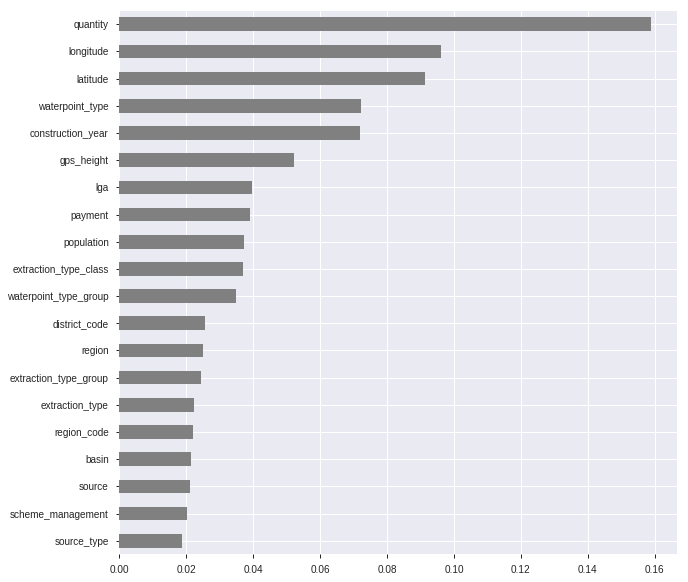

In [39]:
n = 20
plt.figure(figsize=(10, 10))
importances.sort_values()[-n:].plot.barh(color='grey')